STOCK PRICE PREDICTOR USING LSTM

Fetching data for AAPL...
Data fetched: 1255 records from 2020-10-05 to 2025-10-02
Training samples: 944, Test samples: 251
Model built successfully


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0365 - val_loss: 0.0127
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1

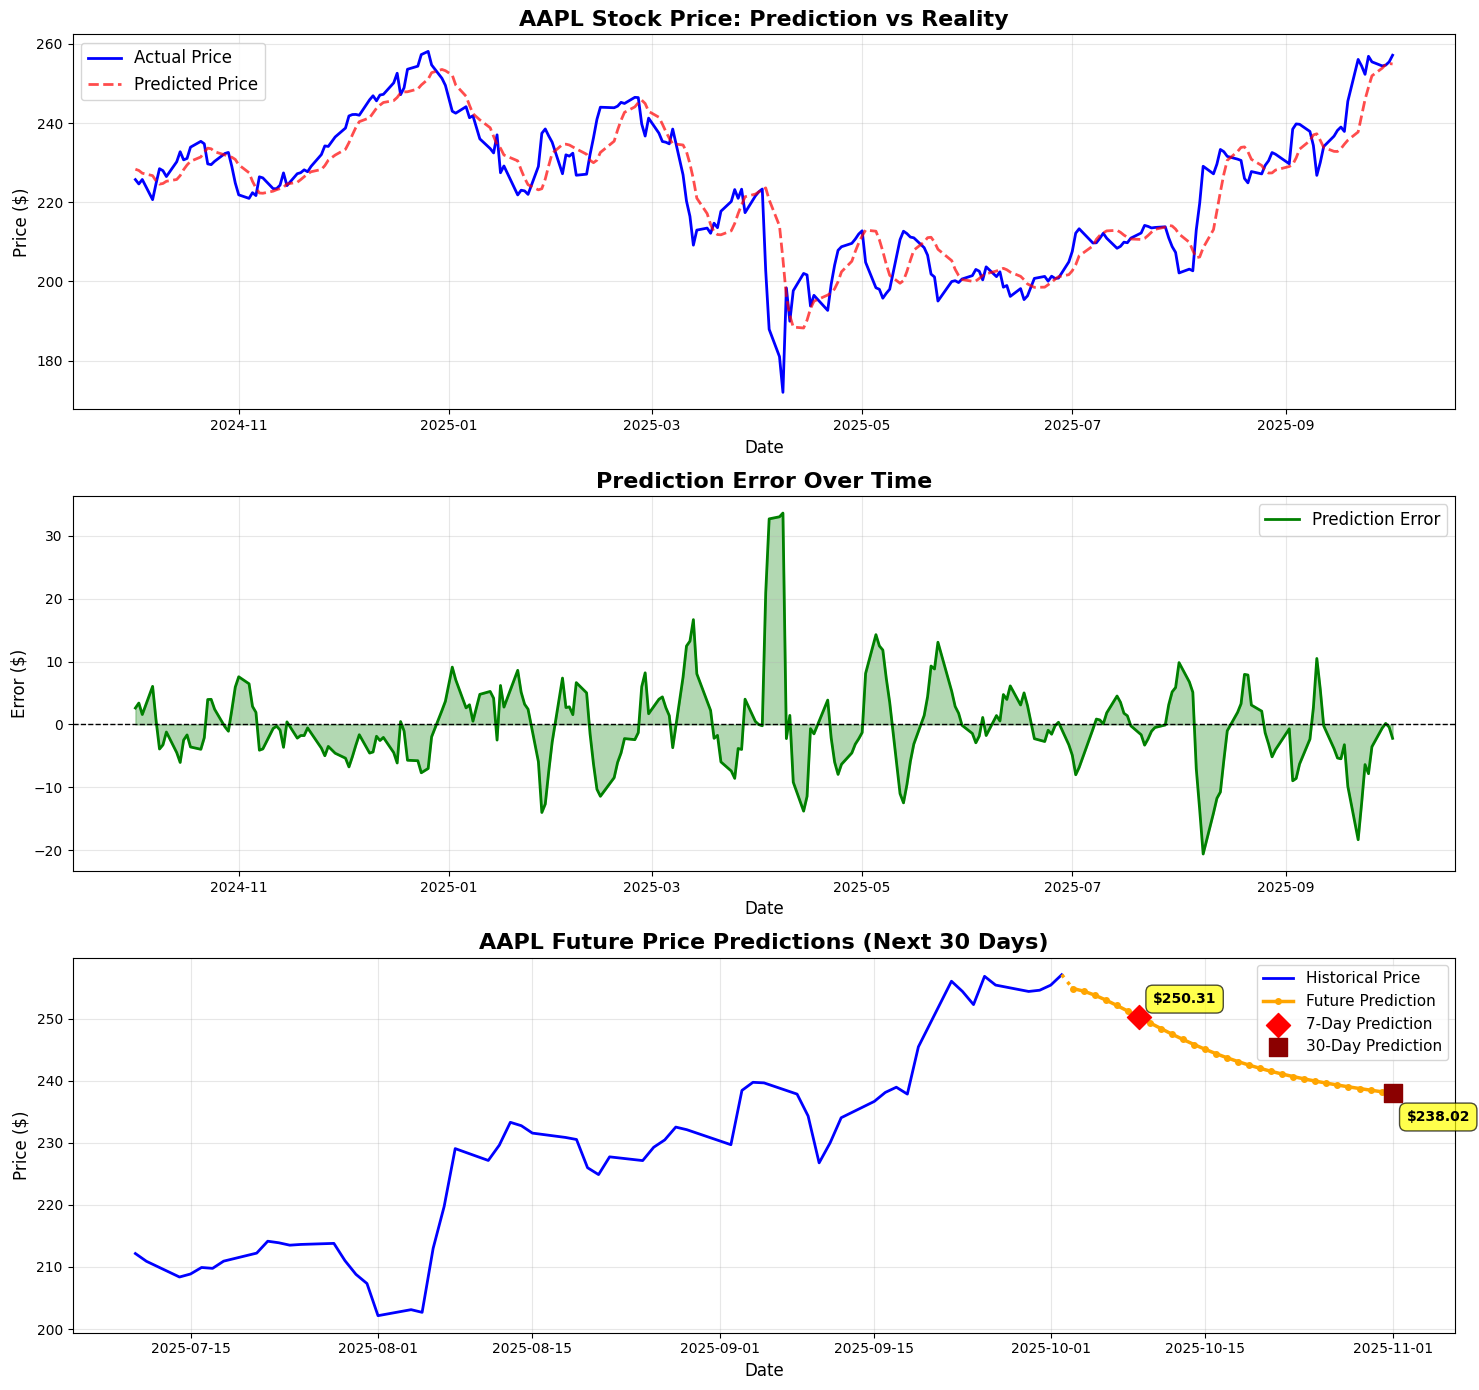


Future predictions for AAPL:
Current price: $257.13
Predicted price in 7 days: $250.31
Predicted price in 30 days: $238.02
Expected change: -7.43%


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

class StockPredictor:

    def __init__(self, ticker='AAPL', lookback_days=60, prediction_days=30):

        self.ticker = ticker
        self.lookback_days = lookback_days
        self.prediction_days = prediction_days
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def fetch_data(self, period='5y'):

        print(f"Fetching data for {self.ticker}...")
        self.df = yf.download(self.ticker, period=period, progress=False)

        if self.df.empty:
            raise ValueError(f"No data found for ticker {self.ticker}")

        print(f"Data fetched: {len(self.df)} records from {self.df.index[0].date()} to {self.df.index[-1].date()}")
        return self.df

    def prepare_data(self, train_split=0.8):

        data = self.df['Close'].values.reshape(-1, 1)

        scaled_data = self.scaler.fit_transform(data)

        train_size = int(len(scaled_data) * train_split)
        self.train_data = scaled_data[:train_size]
        self.test_data = scaled_data[train_size - self.lookback_days:]

        self.X_train, self.y_train = self._create_sequences(self.train_data)
        self.X_test, self.y_test = self._create_sequences(self.test_data)

        print(f"Training samples: {len(self.X_train)}, Test samples: {len(self.X_test)}")

    def _create_sequences(self, data):

        X, y = [], []

        for i in range(self.lookback_days, len(data)):
            X.append(data[i - self.lookback_days:i, 0])
            y.append(data[i, 0])

        X, y = np.array(X), np.array(y)
        X = X.reshape(X.shape[0], X.shape[1], 1)

        return X, y

    def build_model(self, units=50, dropout=0.2, layers=2):

        self.model = Sequential()

        self.model.add(LSTM(units=units, return_sequences=(layers > 1),
                           input_shape=(self.X_train.shape[1], 1)))
        self.model.add(Dropout(dropout))

        for i in range(1, layers):
            return_seq = (i < layers - 1)
            self.model.add(LSTM(units=units, return_sequences=return_seq))
            self.model.add(Dropout(dropout))

        self.model.add(Dense(units=1))

        self.model.compile(optimizer='adam', loss='mean_squared_error')

        print("Model built successfully")
        print(self.model.summary())

    def train(self, epochs=50, batch_size=32, validation_split=0.1):

        # Early stopping to prevent overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=1
        )

        print("Training completed!")
        return history

    def predict(self):

        predictions_scaled = self.model.predict(self.X_test, verbose=0)
        predictions = self.scaler.inverse_transform(predictions_scaled)

        actual_scaled = self.y_test.reshape(-1, 1)
        actual = self.scaler.inverse_transform(actual_scaled)

        return predictions, actual

    def evaluate(self, predictions, actual):

        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        r2 = r2_score(actual, predictions)

        tolerance = 0.05
        accurate_predictions = np.abs((predictions - actual) / actual) <= tolerance
        accuracy = np.mean(accurate_predictions) * 100

        print("\n" + "="*50)
        print("MODEL PERFORMANCE METRICS")
        print("="*50)
        print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
        print(f"Mean Absolute Error (MAE): ${mae:.2f}")
        print(f"R² Score: {r2:.4f}")
        print(f"Accuracy (within 5%): {accuracy:.2f}%")
        print("="*50 + "\n")

        return {'rmse': rmse, 'mae': mae, 'r2': r2, 'accuracy': accuracy}

    def plot_results(self, predictions, actual, future_predictions=None):

        train_size = int(len(self.df) * 0.8)

        start_idx = train_size
        end_idx = start_idx + len(predictions)
        test_dates = self.df.index[start_idx:end_idx]


        if future_predictions is not None:
            fig, axes = plt.subplots(3, 1, figsize=(15, 14))
        else:
            fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        # Plot 1: Prediction vs Actual
        axes[0].plot(test_dates, actual, label='Actual Price', color='blue', linewidth=2)
        axes[0].plot(test_dates, predictions, label='Predicted Price', color='red',
                    linewidth=2, linestyle='--', alpha=0.7)
        axes[0].set_title(f'{self.ticker} Stock Price: Prediction vs Reality',
                         fontsize=16, fontweight='bold')
        axes[0].set_xlabel('Date', fontsize=12)
        axes[0].set_ylabel('Price ($)', fontsize=12)
        axes[0].legend(fontsize=12)
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Prediction Error
        error = predictions.flatten() - actual.flatten()
        axes[1].plot(test_dates, error, label='Prediction Error', color='green', linewidth=2)
        axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1].fill_between(test_dates, error, 0, alpha=0.3, color='green')
        axes[1].set_title('Prediction Error Over Time', fontsize=16, fontweight='bold')
        axes[1].set_xlabel('Date', fontsize=12)
        axes[1].set_ylabel('Error ($)', fontsize=12)
        axes[1].legend(fontsize=12)
        axes[1].grid(True, alpha=0.3)

        # Plot 3: Future Predictions (if provided)
        if future_predictions is not None:

            last_60_days = self.df['Close'].values[-60:].flatten()
            last_60_dates = self.df.index[-60:]


            last_date = self.df.index[-1]
            future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                                        periods=len(future_predictions), freq='D')

            future_pred_array = np.array(future_predictions).flatten()

            # Plot historical data
            axes[2].plot(last_60_dates, last_60_days, label='Historical Price',
                        color='blue', linewidth=2)

            # Plot future predictions
            axes[2].plot(future_dates, future_pred_array, label='Future Prediction',
                        color='orange', linewidth=2.5, marker='o', markersize=4)

            # Highlight 7-day and 30-day predictions
            axes[2].scatter([future_dates[6]], [float(future_pred_array[6])],
                          color='red', s=150, zorder=5, label='7-Day Prediction', marker='D')
            axes[2].scatter([future_dates[29]], [float(future_pred_array[29])],
                          color='darkred', s=150, zorder=5, label='30-Day Prediction', marker='s')

            axes[2].plot([last_60_dates[-1], future_dates[0]],
                        [float(last_60_days[-1]), float(future_pred_array[0])],
                        color='orange', linewidth=2.5, linestyle=':')

            axes[2].set_title(f'{self.ticker} Future Price Predictions (Next 30 Days)',
                            fontsize=16, fontweight='bold')
            axes[2].set_xlabel('Date', fontsize=12)
            axes[2].set_ylabel('Price ($)', fontsize=12)
            axes[2].legend(fontsize=11, loc='best')
            axes[2].grid(True, alpha=0.3)

            axes[2].annotate(f'${float(future_pred_array[6]):.2f}',
                           xy=(future_dates[6], float(future_pred_array[6])),
                           xytext=(10, 10), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                           fontsize=10, fontweight='bold')

            axes[2].annotate(f'${float(future_pred_array[29]):.2f}',
                           xy=(future_dates[29], float(future_pred_array[29])),
                           xytext=(10, -20), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                           fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

    def predict_future(self, days=30):

        # Get last lookback_days of data
        last_sequence = self.df['Close'].values[-self.lookback_days:]
        last_sequence_scaled = self.scaler.transform(last_sequence.reshape(-1, 1))

        future_predictions = []
        current_sequence = list(last_sequence_scaled.flatten())

        for _ in range(days):

            current_batch = np.array(current_sequence).reshape(1, self.lookback_days, 1)

            next_pred_scaled = self.model.predict(current_batch, verbose=0)[0, 0]
            next_pred = self.scaler.inverse_transform([[next_pred_scaled]])[0, 0]
            future_predictions.append(next_pred)

            current_sequence.pop(0)
            current_sequence.append(next_pred_scaled)

        return np.array(future_predictions)


def main():
    """
    Main execution function
    """
    # Configuration
    TICKER = 'AAPL'  # Change to any stock ticker (e.g., 'GOOGL', 'TSLA', 'MSFT')
    LOOKBACK_DAYS = 60

    print("="*60)
    print("STOCK PRICE PREDICTOR USING LSTM")
    print("="*60 + "\n")

    # Initialize predictor
    predictor = StockPredictor(ticker=TICKER, lookback_days=LOOKBACK_DAYS)

    predictor.fetch_data(period='5y')
    predictor.prepare_data(train_split=0.8)

    predictor.build_model(units=50, dropout=0.2, layers=2)
    predictor.train(epochs=50, batch_size=32)

    predictions, actual = predictor.predict()

    metrics = predictor.evaluate(predictions, actual)

    print("\nPredicting next 30 days...")
    future_prices = predictor.predict_future(days=30)

    #Plot
    predictor.plot_results(predictions, actual, future_predictions=future_prices)

    print(f"\nFuture predictions for {TICKER}:")
    current_price = float(predictor.df['Close'].iloc[-1])
    print(f"Current price: ${current_price:.2f}")
    print(f"Predicted price in 7 days: ${future_prices[6]:.2f}")
    print(f"Predicted price in 30 days: ${future_prices[-1]:.2f}")
    print(f"Expected change: {((future_prices[-1] - current_price) / current_price * 100):.2f}%")


if __name__ == "__main__":
    main()